INF6804<br>
Polytechnique Montréal<br>
TP3: Détection et suivi de multiples objets d'intérêt<br>

Auteurs:<br>
Marc-Olivier Bélanger - 1840713<br>
Pierre-Luc Chartier - 1805679

### Déclarations globales

In [108]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import scipy.optimize as sci
import torchvision.models as models
import torchvision.transforms as transforms
import urllib.request as request

In [109]:
COCO_NAMES = ['background']
label_names = request.urlopen('https://raw.githubusercontent.com/gabilodeau/INF6804/master/utils/coco-labels.txt')
for label_name in label_names.readlines():
    COCO_NAMES.append(label_name.strip().decode('UTF-8'))

IOU_THRESHOLD = 0.5
SCORE_THRESHOLD = 0.95

source_path = "/Users/mabelal/Downloads/TP3_data/frames"

model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

In [110]:
# taken from https://answers.opencv.org/question/90455/how-to-perform-intersection-or-union-operations-on-a-rect-in-python/
def intersection_area(a, b):
    x_min = max(a[0], b[0])
    y_min = max(a[1], b[1])
    x_max = min(a[2], b[2])
    y_max = min(a[3], b[3])
    
    width = x_max - x_min
    height = y_max - y_min
    
    return width*height


def union_area(a, b):
    w_a = a[2] - a[0]
    h_a = a[3] - a[1]
    
    w_b = b[2] - b[0]
    h_b = b[3] - b[1]
    
    area_a = w_a * h_a
    area_b = w_b * h_b
    
    return area_a + area_b - intersection_area(a, b)


def intersection_over_union(a, b):
    return intersection_area(a, b) / union_area(a, b)

### Détection des objets (Mask R-CNN)

In [111]:
def detect_objects(img):
    preprocess = transforms.Compose([transforms.ToTensor()])
    tensors = [preprocess(img)]
    
    predictions = model(tensors)
    boxes = []
    
    for p in predictions:
        for j, score in enumerate(p['scores']):
            if score >= SCORE_THRESHOLD:
                label = p['labels'][j]
                is_cup_or_person = (COCO_NAMES[label] == "cup") #or (COCO_NAMES[label] == "person")

                if is_cup_or_person:
                    boxes.append(p['boxes'][j].detach().numpy())
    return boxes

### Description des objets (Histogramme de couleurs)

In [112]:
def calc_color_hist(img, bbox):
    roi = (bbox[0], bbox[1], bbox[2], bbox[3])
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    cv2.rectangle(mask,(roi[0],roi[1]),(roi[2],roi[3]),255,-1,8,0);
    return cv2.calcHist([img],[0],mask,[64],[0,256])


def compare_color_hist(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

### Association des données (Mean-Shift et algorithme hongrois)

In [113]:
def calc_cost_matrix(tracked_objects, current_img, current_bboxes):
    cost_matrix = np.zeros((len(tracked_objects), len(current_bboxes)))
    for i in range(0,len(tracked_objects)):
        for j in range(0,len(current_bboxes)):
            hist_current = calc_color_hist(current_img, current_bboxes[j])
            cost_matrix[i,j] = compare_color_hist(tracked_objects[i].histogram, hist_current)
    return cost_matrix


def mean_shift(tracked_obj, current_img):           
    retro = cv2.calcBackProject([current_img], [0], tracked_obj.histogram, [0,64], 1)

    end_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
    
    to_box = tracked_obj.box()    
    iterations, box = cv2.meanShift(retro, (to_box[0], to_box[1], to_box[2]-to_box[0], to_box[3]-to_box[1]), end_crit)
    x_min, y_min, width, height = box
    
    return x_min, y_min, x_min+width, y_min+height

        
def associate_data(tracked_objects, current_img, current_bboxes):    
    cost_matrix = calc_cost_matrix(tracked_objects, current_img, current_bboxes)
    row_ind, col_ind = sci.linear_sum_assignment(cost_matrix)
    
    for i in range(0, len(row_ind)):
        # check if association from hungarian algorithm makes sense based on IOU
        iou_score = intersection_over_union(tracked_objects[row_ind[i]].box(), current_bboxes[col_ind[i]])
        if iou_score > IOU_THRESHOLD:
            # model detected object, update it with its predicted bbox
            tracked_objects[row_ind[i]].was_detected = True
            x_min, y_min, x_max, y_max = current_bboxes[col_ind[i]]
            tracked_objects[row_ind[i]].update(x_min, y_min, x_max, y_max)
    
    # apply mean-shift to tracked objects that were not detected by the model
    # update to predicted box if IOU > threshold
    for ob in tracked_objects.values():
        if not ob.was_detected:
            x_min, y_min, x_max, y_max = mean_shift(ob, current_img)
            
            iou_score = intersection_over_union(ob.box(), (x_min, y_min, x_max, y_max))
            if iou_score > IOU_THRESHOLD:
                ob.update(x_min, y_min, x_max, y_max)
        else:
            # reset for next frame
            ob.was_detected = False          
            
    return row_ind, col_ind

### Algorithme principal

In [114]:
class TrackedObject:
    def __init__(self, object_id, x_min, y_min, x_max, y_max):
        self.object_id = object_id
        self.count = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.was_detected = False
        self.histogram = None
    
    
    def update(self, x_min, y_min, x_max, y_max, count = None):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        
        if count is not None:
            self.count = count
            
    
    def box(self):
        return self.x_min, self.y_min, self.x_max, self.y_max
    
    
    def __str__(self):
        ws = " "
        return ws.join([str(self.object_id+1), str(round(self.x_min)),
                        str(round(self.x_max)), str(round(self.y_min)), str(round(self.y_max))])

In [115]:
def algo(path_to_frames, tracked_objects, result_file):
    # some magic to get the frames in the right order
    frames = [name for name in os.listdir(path_to_frames) if os.path.isfile(os.path.join(path_to_frames, name))]
    frames = sorted(frames)
    frames = sorted(frames, key = lambda s : len(s))
    
    # initial frame
    prev_img = cv2.imread(os.path.join(path_to_frames, frames[0]), cv2.IMREAD_GRAYSCALE)
    for ob in tracked_objects.values():
        ob.histogram = calc_color_hist(prev_img, ob.box())
    
    f = open(result_file, "w+")
    for i in range(0, len(tracked_objects)):
        f.write("1 " + str(tracked_objects[i]) + "\n")
    
    # main loop
    for i in range(1, len(frames)):
        img = cv2.imread(os.path.join(path_to_frames, frames[i]), cv2.IMREAD_GRAYSCALE)
        boxes = detect_objects(img)
        associate_data(tracked_objects, img, boxes)
        
        for j in range(0, len(tracked_objects)):
            f.write(str(i+1) + " " + str(tracked_objects[j]) + "\n")
        
        prev_img = img
        
        if (i % 5) == 0:
            print("Progress: " + frames[i])
    
    f.close()

In [116]:
def algo_mot():
    return None

### Test de l'association des données

1 588 799 363 577
2 1062 1441 555 981


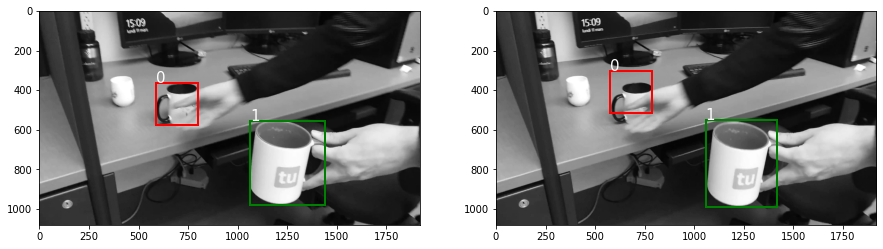

1 574 785 302 516
2 1058 1420 549 991


In [117]:
### Test association des données ###

img = cv2.imread(os.path.join(source_path, "frame124.jpg"), cv2.IMREAD_GRAYSCALE)
cup_1 = TrackedObject(0, 588, 363, 799, 577)
cup_2 = TrackedObject(1, 1062, 555, 1441, 981)

# modelisation des objets a partir de la premiere image
first_img = cv2.imread(os.path.join(source_path, "frame1.jpg"), cv2.IMREAD_GRAYSCALE)
cup_1.histogram = calc_color_hist(first_img, cup_1.box())
cup_2.histogram = calc_color_hist(first_img, cup_2.box())

tracked_objects = {
    cup_1.object_id : cup_1,
    cup_2.object_id : cup_2
}

img2 = cv2.imread(os.path.join(source_path, "frame125.jpg"), cv2.IMREAD_GRAYSCALE)
b2 = detect_objects(img2)

fig, axarr = plt.subplots(1, 2, figsize=(15,15))
bboxcolor = 'rgbcmy'

axarr[0].imshow(img, cmap = plt.cm.gray)
for i in range(0, len(tracked_objects)):
    b = tracked_objects[i].box()
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[0].add_patch(rect)
    axarr[0].text(b[0], b[1], i, color='white', fontsize=15)

for to in tracked_objects.values():
    print(to)

row_ind, col_ind = associate_data(tracked_objects, img2, b2)
#print(row_ind)
#print(col_ind)

axarr[1].imshow(img2, cmap = plt.cm.gray)
#for i, b in enumerate(b2):
for i in range(0, len(tracked_objects)):
    b = tracked_objects[i].box()
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    rect = patches.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor=bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    axarr[1].text(b[0], b[1], i, color='white', fontsize=15)
    
plt.show()

for to in tracked_objects.values():
    print(to)

############

### MOT17-11: Forward moving camera in a busy shopping mall

In [118]:
# calcul du MOTA en utilisant IoU > 50%

# will need to create tracked_objects or smtg
# call algo, print in results file, then use the file to compute MOTA

### MOT17-05: Street scene from a moving platform

In [119]:
# calcul du MOTA en utilisant IoU > 50%

### MOT17-13 : Filmed from a bus on a busy intersection

In [120]:
# calcul du MOTA en utilisant IoU > 50%

### Résultats sur les trames fournies

In [ ]:
# init.txt
cup_1 = TrackedObject(0, 830, 474, 1112, 755)
cup_2 = TrackedObject(1, 1194, 433, 1479, 700)

tracked_objects = {
    cup_1.object_id : cup_1,
    cup_2.object_id : cup_2
}


algo("/Users/mabelal/Downloads/TP3_data/frames", tracked_objects, "result_cups.txt")

Progress: frame6.jpg
Progress: frame11.jpg
Progress: frame16.jpg
Progress: frame21.jpg
Progress: frame26.jpg
Progress: frame31.jpg
Progress: frame36.jpg
Progress: frame41.jpg
Progress: frame46.jpg
Progress: frame51.jpg
Progress: frame56.jpg


### Validation des résultats

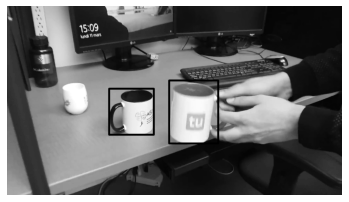

frame101.jpg
101 1 585 841 472 735

101 2 929 1210 425 785



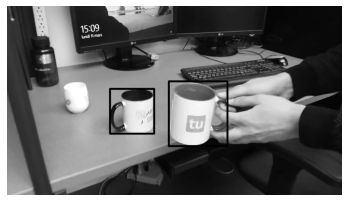

frame102.jpg
102 1 590 843 473 729

102 2 927 1263 430 800



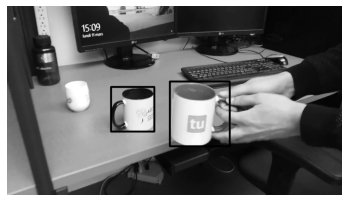

frame103.jpg
103 1 596 844 462 717

103 2 933 1276 431 801



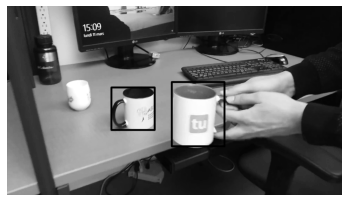

frame104.jpg
104 1 598 846 465 708

104 2 944 1246 434 801



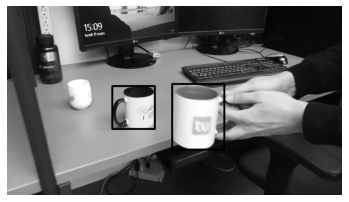

frame105.jpg
105 1 603 847 457 702

105 2 946 1245 445 820



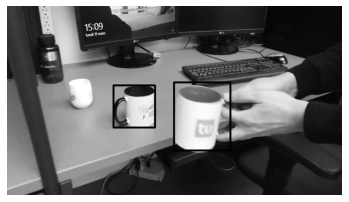

frame106.jpg
106 1 610 848 453 694

106 2 957 1280 436 825



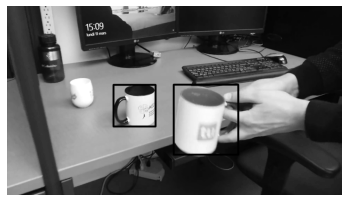

frame107.jpg
107 1 610 851 450 688

107 2 955 1325 449 849



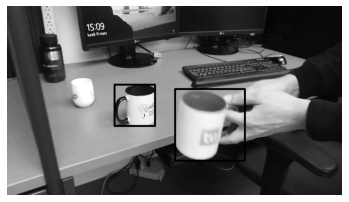

frame108.jpg
108 1 616 848 449 685

108 2 963 1363 474 884



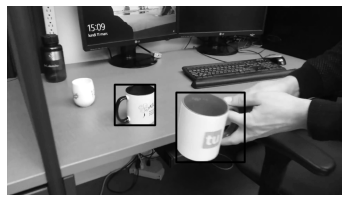

frame109.jpg
109 1 617 849 449 681

109 2 970 1362 494 892



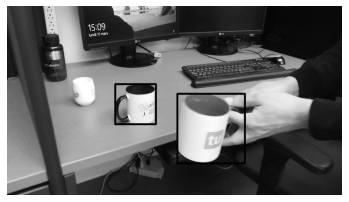

frame110.jpg
110 1 620 853 446 675

110 2 976 1363 501 899



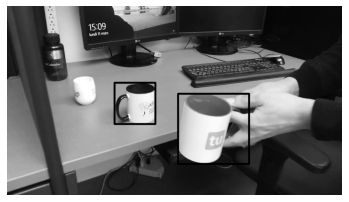

frame111.jpg
111 1 616 850 438 674

111 2 980 1387 501 902



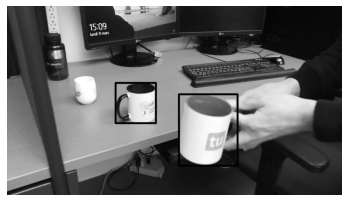

frame112.jpg
112 1 622 853 439 669

112 2 985 1321 504 912



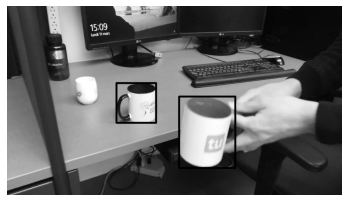

frame113.jpg
113 1 627 854 440 667

113 2 986 1308 517 925



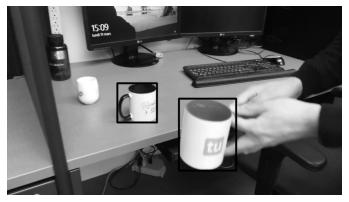

frame114.jpg
114 1 632 859 441 665

114 2 985 1313 529 940



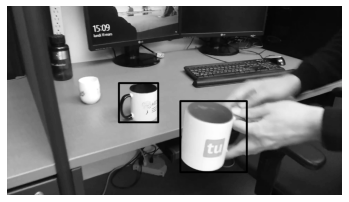

frame115.jpg
115 1 641 866 440 664

115 2 993 1374 543 949



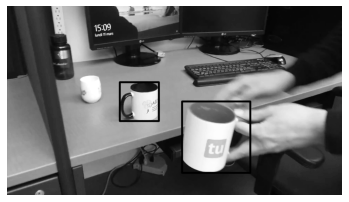

frame116.jpg
116 1 646 870 435 657

116 2 1003 1394 545 953



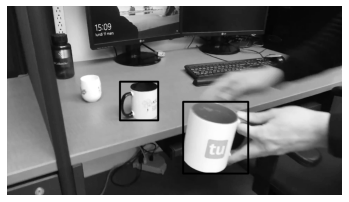

frame117.jpg
117 1 647 866 432 653

117 2 1009 1382 547 957



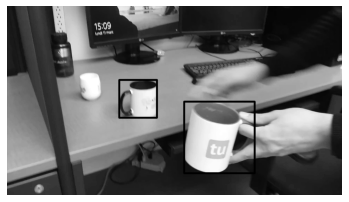

frame118.jpg
118 1 643 859 422 638

118 2 1015 1419 546 955



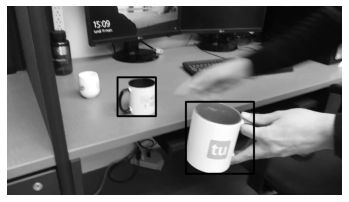

frame119.jpg
119 1 633 853 407 629

119 2 1025 1415 547 958



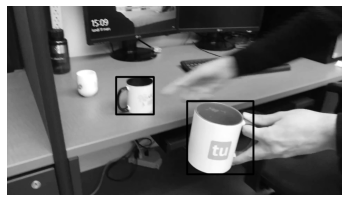

frame120.jpg
120 1 625 841 405 619

120 2 1032 1412 543 961



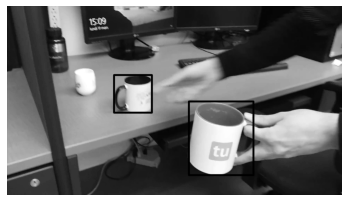

frame121.jpg
121 1 613 830 394 609

121 2 1042 1412 545 966



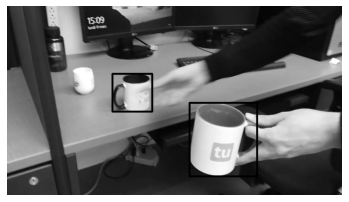

frame122.jpg
122 1 604 832 387 603

122 2 1046 1433 553 973



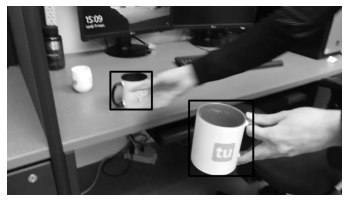

frame123.jpg
123 1 592 830 375 591

123 2 1043 1411 540 971



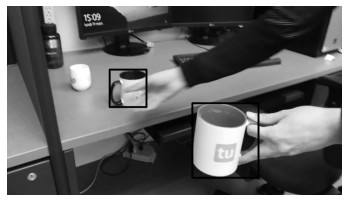

frame124.jpg
124 1 588 799 363 577

124 2 1062 1441 555 981



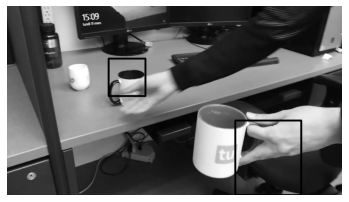

frame125.jpg
125 1 582 793 300 514

125 2 1308 1686 654 1080



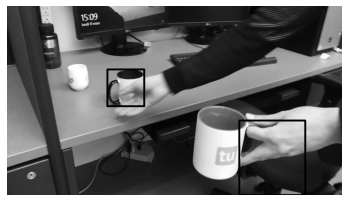

frame126.jpg
126 1 575 786 362 572

126 2 1331 1709 654 1080



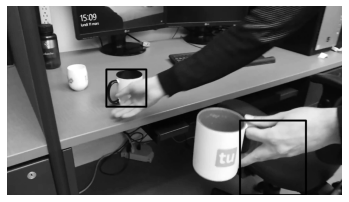

frame127.jpg
127 1 569 798 362 575

127 2 1335 1713 654 1080



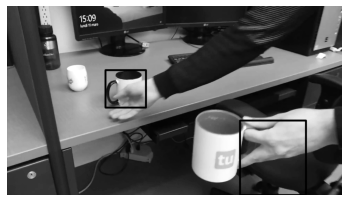

frame128.jpg
128 1 564 796 366 580

128 2 1335 1713 654 1080



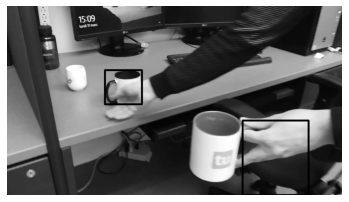

frame129.jpg
129 1 561 773 366 561

129 2 1350 1728 654 1080



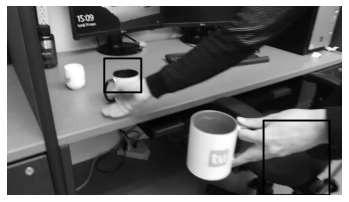

frame130.jpg
130 1 557 769 299 493

130 2 1470 1848 654 1080



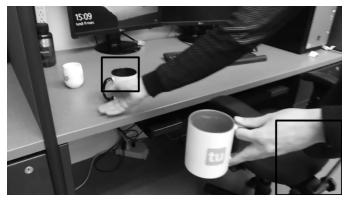

frame131.jpg
131 1 543 755 293 487

131 2 1542 1920 654 1080



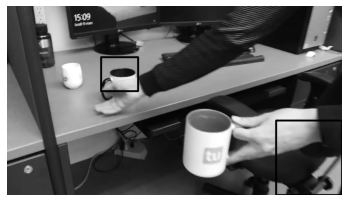

frame132.jpg
132 1 539 751 292 486

132 2 1542 1920 654 1080



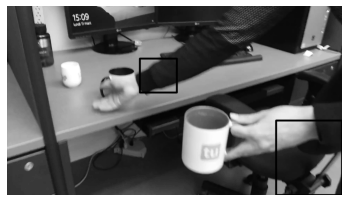

frame133.jpg
133 1 761 973 300 494

133 2 1542 1920 654 1080



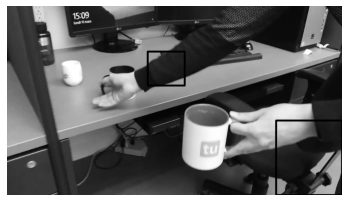

frame134.jpg
134 1 806 1018 260 454

134 2 1542 1920 654 1080



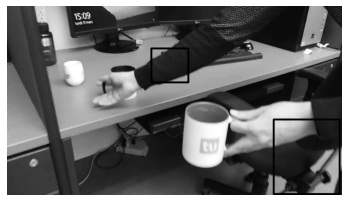

frame135.jpg
135 1 827 1039 242 436

135 2 1528 1906 648 1074



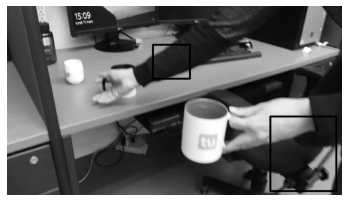

frame136.jpg
136 1 836 1048 221 415

136 2 1509 1887 631 1057



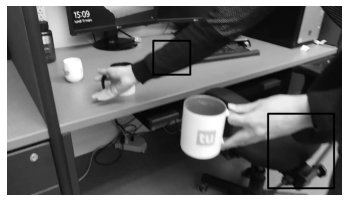

frame137.jpg
137 1 838 1050 198 392

137 2 1496 1874 615 1041



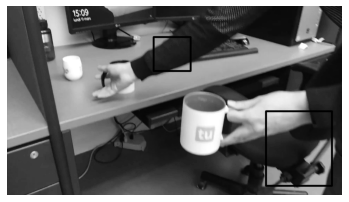

frame138.jpg
138 1 840 1052 177 371

138 2 1484 1862 601 1027



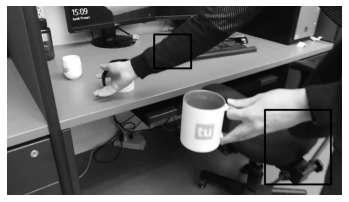

frame139.jpg
139 1 843 1055 162 356

139 2 1478 1856 593 1019



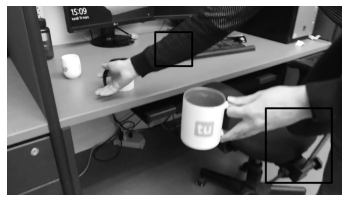

frame140.jpg
140 1 849 1061 149 343

140 2 1483 1861 584 1010



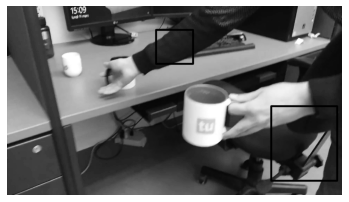

frame141.jpg
141 1 854 1066 136 330

141 2 1514 1892 572 998



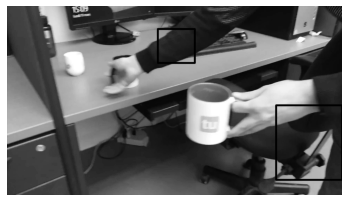

frame142.jpg
142 1 864 1076 131 325

142 2 1542 1920 567 993



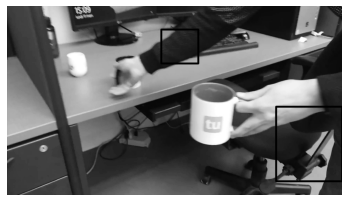

frame143.jpg
143 1 884 1096 134 328

143 2 1542 1920 575 1001



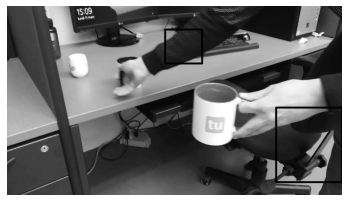

frame144.jpg
144 1 906 1118 134 328

144 2 1542 1920 580 1006



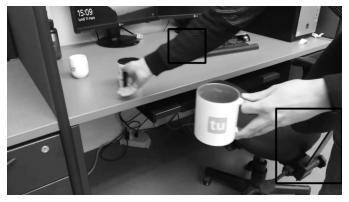

frame145.jpg
145 1 925 1137 131 325

145 2 1542 1920 586 1012



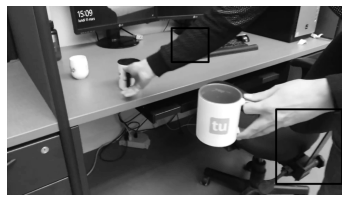

frame146.jpg
146 1 943 1155 126 320

146 2 1542 1920 590 1016



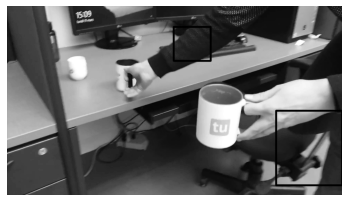

frame147.jpg
147 1 955 1167 119 313

147 2 1542 1920 598 1024



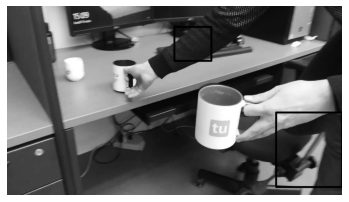

frame148.jpg
148 1 959 1171 119 313

148 2 1542 1920 608 1034



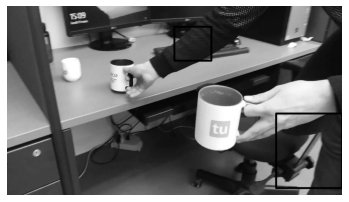

frame149.jpg
149 1 959 1171 118 312

149 2 1542 1920 614 1040



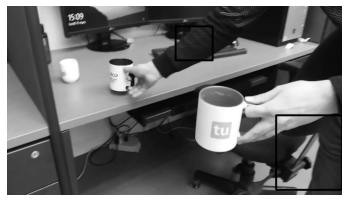

frame150.jpg
150 1 966 1178 116 310

150 2 1542 1920 624 1050



In [75]:
### Validation des résultats

f = open("result_cups.txt", "r")
lines = f.readlines()
f.close()

frames = [name for name in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, name))]
frames = sorted(frames)
frames = sorted(frames, key = lambda s : len(s))

i = 101
for j in range (0, 50):
    img = cv2.imread(os.path.join(source_path, frames[i-1+j]), cv2.IMREAD_GRAYSCALE)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))+1].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis("off")
    plt.show()
    
    print(frames[i-1+j])
    print(lines[(2*(i-1+j))])
    print(lines[(2*(i-1+j))+1])
